# Parte 1 - Análise exploratória
--- 

Esta etapa será fundamental para entender os dados e gerar insights sobre como estes podem ser utilizados para responder às perguntas do negócio, isto é, para criação dos sistemas das Partes 2 e 3.

## 0. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid');
matplotlib.style.use('ggplot');
import string

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer, TfidfTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RepeatedStratifiedKFold

import sklearn.externals
import joblib

/home/igorsr/Projetos/teste_elo7/venv/lib/python3.8/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## 1. Carregamento dos dados

In [2]:
df_data_raw = pd.read_csv("data/elo7_recruitment_dataset.csv")
df_data_raw.head()

,product_id,seller_id,query,search_page,position,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category
0,11394449,8324141,espirito santo,2,6,Mandala Espírito Santo,mandala mdf,2015-11-14 19:42:12,171.890000,1200.0,1,4,244,NaN,Decoração
1,15534262,6939286,cartao de visita,2,0,Cartão de Visita,cartao visita panfletos tag adesivos copos lon...,2018-04-04 20:55:07,77.670000,8.0,1,5,124,NaN,Papel e Cia
2,16153119,9835835,expositor de esmaltes,1,38,Organizador expositor p/ 70 esmaltes,expositor,2018-10-13 20:57:07,73.920006,2709.0,1,1,59,NaN,Outros
3,15877252,8071206,medidas lencol para berco americano,1,6,Jogo de Lençol Berço Estampado,t jogo lencol menino lencol berco,2017-02-27 13:26:03,118.770004,0.0,1,1,180,1.0,Bebê
4,15917108,7200773,adesivo box banheiro,3,38,ADESIVO BOX DE BANHEIRO,adesivo box banheiro,2017-05-09 13:18:38,191.810000,507.0,1,6,34,NaN,Decoração


## 2.0. Descrição dos dados

In [3]:
df1 = df_data_raw.copy()

### 2.1. Análise do volume de dados

In [4]:
print(f'O dataset possui {df1.shape[0]} linhas e {df1.shape[1]} colunas.')

O dataset possui 38507 linhas e 15 colunas.


Como o dataset é relativamente pequeno serão utilizadas as bibliotecas **pandas** e **scikit-learn**.
Para reprodução desta análise utilizando mais dados (da ordem de milhões de amostras) será necessário utilizar outras bibliotecas, como Spark ou Dask.

### 2.2. Análise dos tipos de dados

In [5]:
df1.dtypes

product_id             int64
seller_id              int64
query                 object
search_page            int64
position               int64
title                 object
concatenated_tags     object
creation_date         object
price                float64
weight               float64
express_delivery       int64
minimum_quantity       int64
view_counts            int64
order_counts         float64
category              object
dtype: object

Será necessário mudar os tipo creation_date para datetime:

In [6]:
df1['creation_date'] = pd.to_datetime(df1['creation_date'])

In [7]:
df1.dtypes

product_id                    int64
seller_id                     int64
query                        object
search_page                   int64
position                      int64
title                        object
concatenated_tags            object
creation_date        datetime64[ns]
price                       float64
weight                      float64
express_delivery              int64
minimum_quantity              int64
view_counts                   int64
order_counts                float64
category                     object
dtype: object

### 2.3 Verificação e tratamento de dados faltantes

Número absoluto e relativo de valores nulos ou ausentes de cada feature:

In [8]:
df_nulos = df1.isna().sum().sort_values(ascending = False)
df_nulos = pd.concat([df_nulos, df_nulos * 100 / len(df1)], axis=1).reset_index(0)

df_nulos.columns = ['Feature', 'Count N/A', '% N/A']
display(df_nulos)

,Feature,Count N/A,% N/A
0,order_counts,20390,52.951411
1,weight,58,0.150622
2,concatenated_tags,2,0.005194
3,product_id,0,0.000000
4,seller_id,0,0.000000
5,query,0,0.000000
6,search_page,0,0.000000
7,position,0,0.000000
8,title,0,0.000000
9,creation_date,0,0.000000


Portanto as features **order_counts**, **weight** e **concatenated_tags** possuem dados faltantes.

#### 2.3.1. Preenchendo valores faltantes de  order_counts

'order_counts' indica o número de vendas do produto nos últimos 3 meses. Portanto, irei substituir estes valores N/A por 0:

In [9]:
df1['order_counts'] = df1['order_counts'].fillna(0).astype('int64')

#### 2.3.2. Preenchendo valores faltantes de  concatenated_tags

Em relação à feature 'concatenated_tags', o valor nulo indica que o vendedor não adicionou uma tag ao seu produto. Portanto irei substituir por uma string vazia:

In [10]:
df1['concatenated_tags'] = df1['concatenated_tags'].fillna('')

#### 2.3.3. Preenchendo valores faltantes de 'weight'

**Vamos verificar se há muitas linhas com 'weight' igual a 0:**


In [11]:
print("Amostras com 'weight' igual a 0:", len(df1[df1['weight'] == 0]))
print("Percentual de amostras com 'weight' igual a 0:", 100*len(df1[df1['weight'] == 0])/df1.shape[0])

Amostras com 'weight' igual a 0: 4398
Percentual de amostras com 'weight' igual a 0: 11.421300023372375


Como mais de 11% das linhas peso igual a 0 irei atribuir este valor aos dados fantantes:

In [12]:
df1['weight'] = df1['weight'].fillna(0)

In [13]:
df1.isna().sum().sort_values(ascending = False)

product_id           0
seller_id            0
query                0
search_page          0
position             0
title                0
concatenated_tags    0
creation_date        0
price                0
weight               0
express_delivery     0
minimum_quantity     0
view_counts          0
order_counts         0
category             0
dtype: int64

#### 2.3.4. Função de limpeza/transformação dos dados

Esta função agrega todas as transformações de tipos e tratamento de missing values necessárias.

In [14]:
def data_cleaning(df):    
    df['concatenated_tags'] = df['concatenated_tags'].fillna('')    
    df['order_counts'] = df['order_counts'].fillna(0).astype('int64')    
    df['weight'] = df['weight'].fillna(0)
    df['creation_date'] = pd.to_datetime(df['creation_date'])
    return df

### 2.4. Resumo geral dos dados

In [15]:
df1.dtypes

product_id                    int64
seller_id                     int64
query                        object
search_page                   int64
position                      int64
title                        object
concatenated_tags            object
creation_date        datetime64[ns]
price                       float64
weight                      float64
express_delivery              int64
minimum_quantity              int64
view_counts                   int64
order_counts                  int64
category                     object
dtype: object

#### 2.4.1. Atributos numéricos

In [16]:
def estatistica_descritiva_atributos_numericos(df):
    
    atributos_numericos = df.select_dtypes(include=['int64','float64'])
    
    # medidas de tendência central
    media   = pd.DataFrame(atributos_numericos.apply(np.mean))
    mediana = pd.DataFrame(atributos_numericos.apply(np.median))
    
    # medidas de dispersão
    std   = pd.DataFrame(atributos_numericos.apply(np.std))
    min   = pd.DataFrame(atributos_numericos.apply(np.min))
    max   = pd.DataFrame(atributos_numericos.apply(np.max))
    
    range = pd.DataFrame(atributos_numericos.apply(lambda x: x.max() - x.min()))
    skew = pd.DataFrame(atributos_numericos.apply(lambda x: x.skew()))
    kurtosis = pd.DataFrame(atributos_numericos.apply(lambda x: x.kurtosis()))
       

    df_stat = pd.concat([media, mediana, std, min, max, range, skew, kurtosis ], axis=1).reset_index()
    df_stat.columns = ['Atributo', 'Média', 'Médiana', 'Std', 'Min', 'Max', 'Intervalo', 'Skew', 'Kurtosis']
    return df_stat

In [17]:
display(estatistica_descritiva_atributos_numericos(df1.drop(['product_id', 'seller_id'], axis=1)))

,Atributo,Média,Médiana,Std,Min,Max,Intervalo,Skew,Kurtosis
0,search_page,1.491885,1.00,0.980558,1.00,5.00,4.00,2.115566,3.689708
1,position,16.889007,16.00,11.588384,0.00,38.00,38.00,0.214027,-1.206105
2,price,84.054157,28.49,211.802560,0.07,11509.38,11509.31,17.471604,524.144986
3,weight,361.291739,9.00,1819.473395,0.00,65009.00,65009.00,16.779927,411.873144
4,express_delivery,0.780637,1.00,0.413815,0.00,1.00,1.00,-1.356395,-0.160200
5,minimum_quantity,14.596567,7.00,43.768369,0.00,3000.00,3000.00,29.651200,1357.728032
6,view_counts,545.520503,242.00,1416.490209,1.00,45010.00,45009.00,14.750511,321.535498
7,order_counts,12.882567,0.00,43.711358,0.00,2460.00,2460.00,16.420026,494.590215


## 3.0 Feature engineering

### Análise do tamanho das consultas (em número de caracteres) por categoria

In [18]:
df1['query_length'] = df1['query'].apply(len)

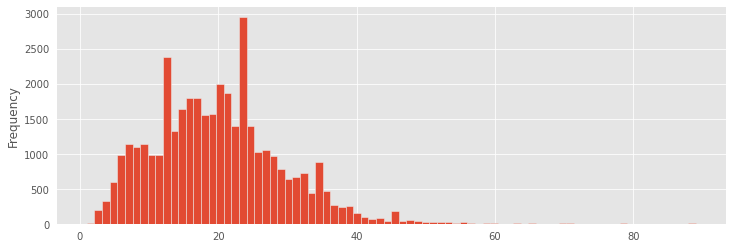

In [19]:
fig = plt.figure(figsize=(12,4))
df1['query_length'].plot.hist(bins=80);

/home/igorsr/Projetos/teste_elo7/venv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


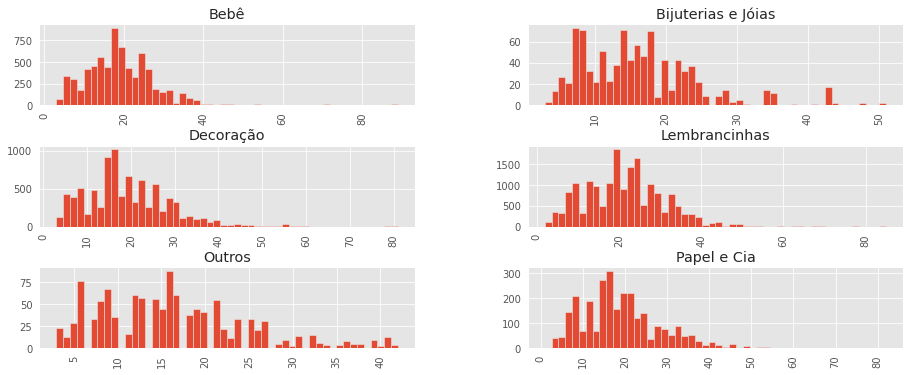

In [20]:
df1.hist(column='query_length', by='category', bins=50, figsize=(15,6));

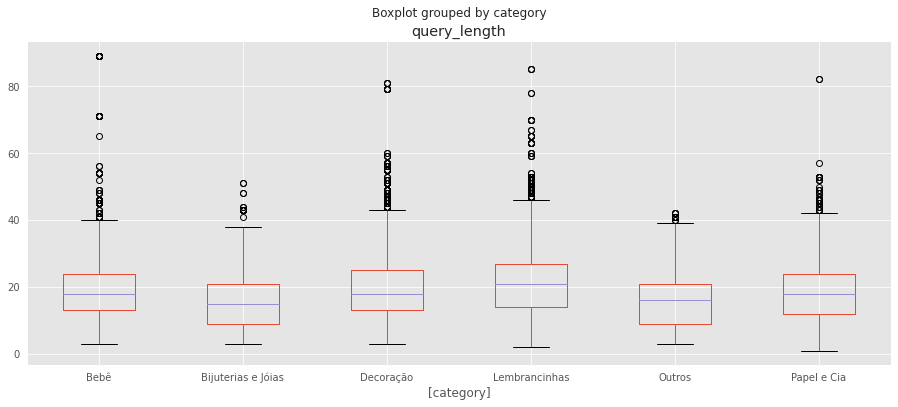

In [21]:
df1.boxplot(column=["query_length"], by=["category"], figsize=(15,6));

## 4.0. Análise exploratória

In [22]:
df2 = df1.copy()

In [23]:
atributos_numericos = df2.select_dtypes(include=['int64', 'float64']).drop(['product_id', 'seller_id'], axis=1)

### 4.1 Análise univariada - Qual a distribuição de cada variável?

#### 4.1.1 Análise das classes utilizadas no sistema de classificação

O dataset possui as seguintes categorias:

In [24]:
class_names = df2['category'].unique()
print(class_names)

['Decoração' 'Papel e Cia' 'Outros' 'Bebê' 'Lembrancinhas'
 'Bijuterias e Jóias']


Percentual de cada categoria no dataset:

In [25]:
cat_counts = df2['category'].value_counts(normalize=True)*100
display(cat_counts)

Lembrancinhas         46.118887
Decoração             22.972447
Bebê                  18.246033
Papel e Cia            7.211676
Outros                 2.981276
Bijuterias e Jóias     2.469681
Name: category, dtype: float64

Visualização da frequência de cada categoria no dataset:

Text(0.5, 0, 'Categoria')

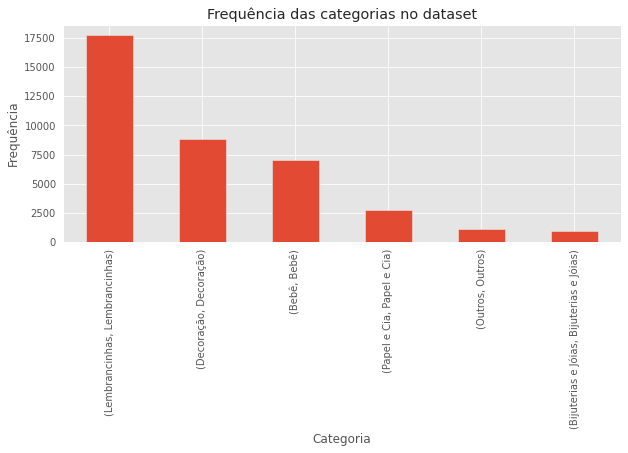

In [26]:
fit = plt.figure(figsize=(10,4))
ax = plt.axes()

df2.groupby('category')['category'].value_counts().sort_values(ascending=False).plot.bar();

ax.set_title("Frequência das categorias no dataset")
ax.set_ylabel("Frequência")
ax.set_xlabel("Categoria")

**Podemos concluir que o dataset é desbalanceado, com 46.11% das amostras pertencendo à classe 'Lembrancinhas', enquanto duas classes ('Outros' e 'Bijuterias e Jóias') possuem menos de 3% de representatividade. Portanto, isto deverá ser levado em consideração durante o treinamento dos modelos.**

#### 4.1.2. Features numéricas

In [27]:
atributos_numericos.columns

Index(['search_page', 'position', 'price', 'weight', 'express_delivery',
       'minimum_quantity', 'view_counts', 'order_counts', 'query_length'],
      dtype='object')

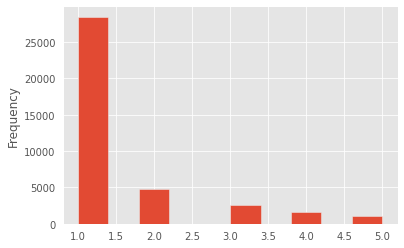

In [28]:
#fig=plt.figure(figsize=(12,6))
atributos_numericos['search_page'].plot.hist();

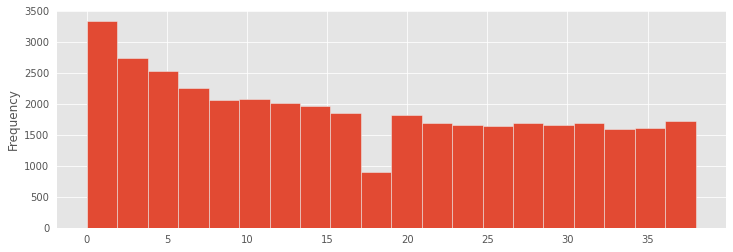

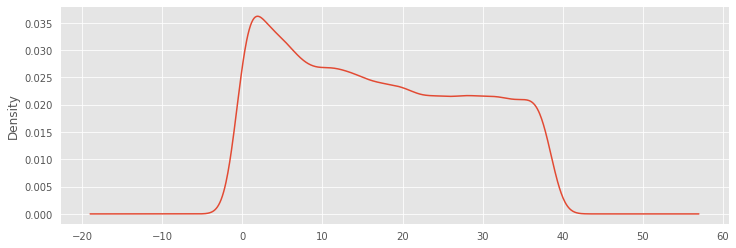

In [29]:
fig=plt.figure(figsize=(12,4))
atributos_numericos['position'].plot.hist(bins=20);
fig=plt.figure(figsize=(12,4))
atributos_numericos['position'].plot.kde();

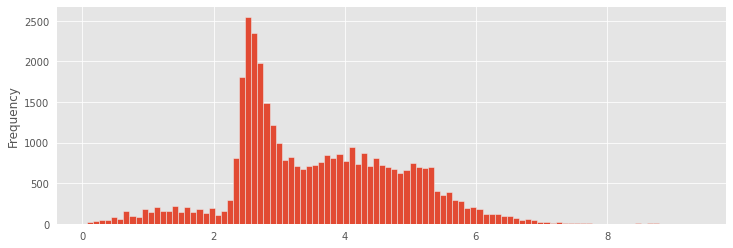

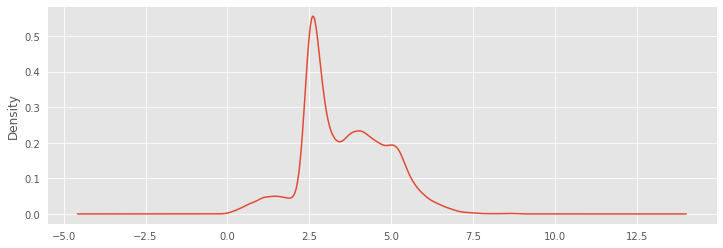

In [30]:
atributos_numericos['log_price'] = np.log1p(atributos_numericos['price']);
fig=plt.figure(figsize=(12,4))
atributos_numericos['log_price'].plot.hist(bins=100);
fig=plt.figure(figsize=(12,4))
atributos_numericos['log_price'].plot.kde();

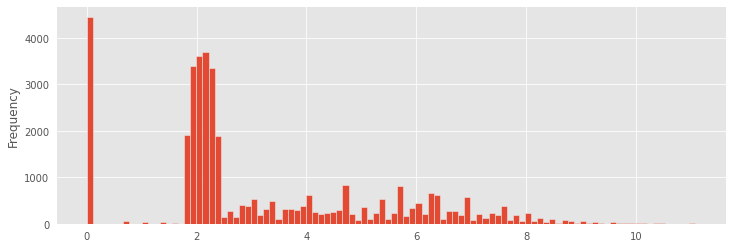

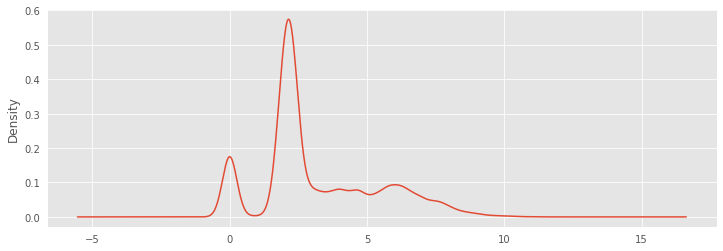

In [31]:
#fig=plt.figure(figsize=(12,4))
#atributos_numericos['weight'].plot.hist(bins=200);
#plt.show();

atributos_numericos['log_weight'] = np.log1p(atributos_numericos['weight']);
fig=plt.figure(figsize=(12,4))
atributos_numericos['log_weight'].plot.hist(bins=100);
fig=plt.figure(figsize=(12,4))
atributos_numericos['log_weight'].plot.kde();

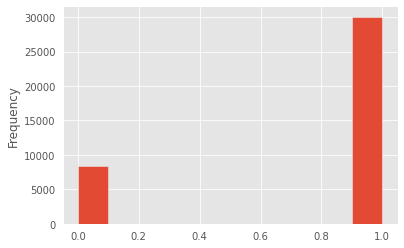

In [32]:
#fig=plt.figure(figsize=(12,4))
atributos_numericos['express_delivery'].plot.hist();

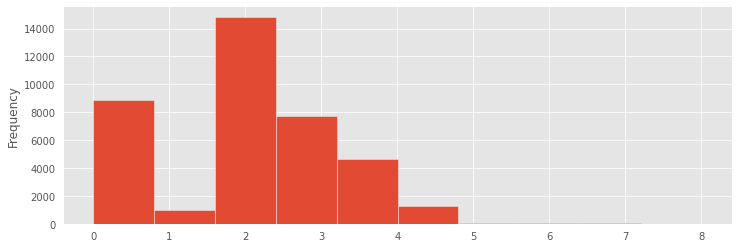

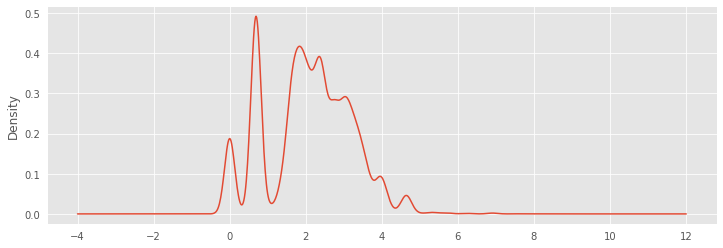

In [33]:
#fig=plt.figure(figsize=(12,4))
#atributos_numericos['minimum_quantity'].plot.hist();
#plt.show();

atributos_numericos['log_minimum_quantity'] = np.log1p(atributos_numericos['minimum_quantity']);
fig=plt.figure(figsize=(12,4))
atributos_numericos['log_minimum_quantity'].plot.hist(bins=10);
fig=plt.figure(figsize=(12,4))
atributos_numericos['log_minimum_quantity'].plot.kde();

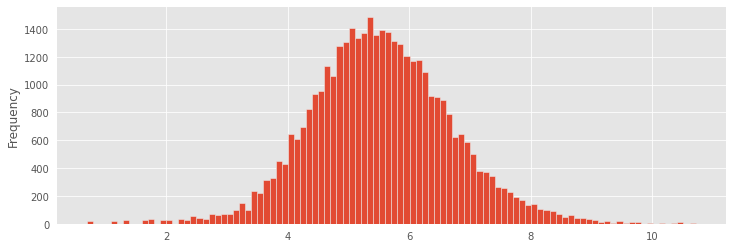

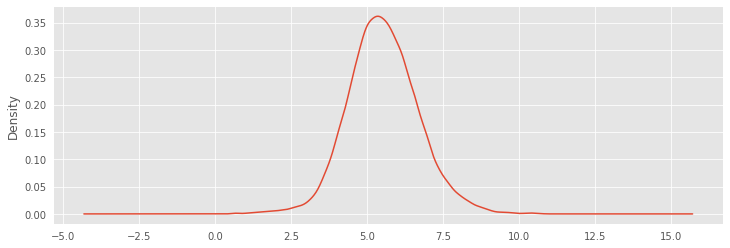

In [34]:
#fig=plt.figure(figsize=(12,4))
#atributos_numericos['view_counts'].plot.hist(bins=100);
#plt.show();

fig=plt.figure(figsize=(12,4))
atributos_numericos['log_view_counts'] = np.log1p(atributos_numericos['view_counts']);
atributos_numericos['log_view_counts'].plot.hist(bins=100);
fig=plt.figure(figsize=(12,4))
atributos_numericos['log_view_counts'].plot.kde();

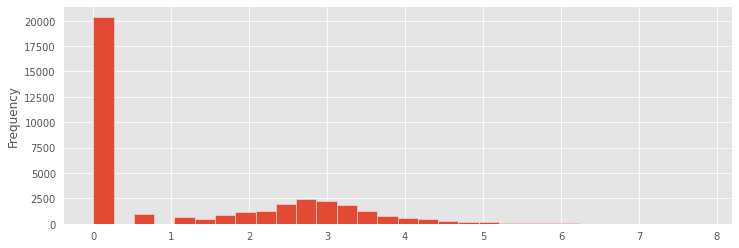

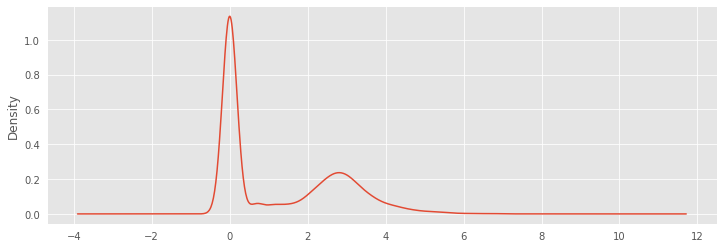

In [35]:

#fig=plt.figure(figsize=(12,4))
df_order = atributos_numericos.copy()

#df_order['order_counts'].plot.hist(bins=50);
#plt.show();

fig=plt.figure(figsize=(12,4))
df_order['log_order_counts'] = np.log1p(df_order['order_counts']);
df_order['log_order_counts'].plot.hist(bins=30);

fig=plt.figure(figsize=(12,4))
df_order['log_order_counts'].plot.kde();

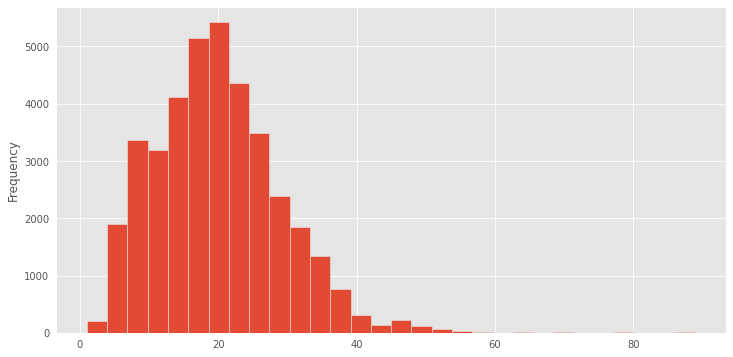

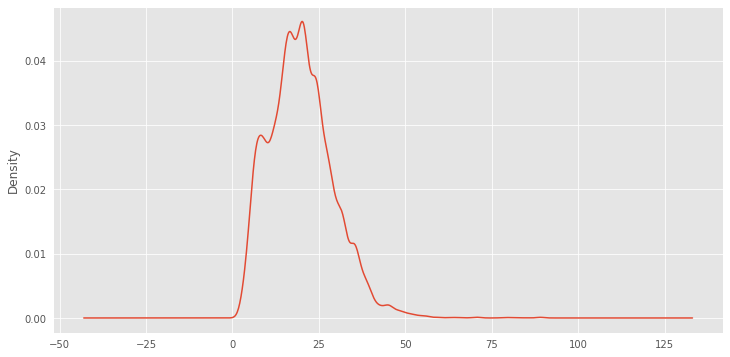

In [36]:
fig=plt.figure(figsize=(12,6))
atributos_numericos['query_length'].plot.hist(bins=30);
fig=plt.figure(figsize=(12,6))
atributos_numericos['query_length'].plot.kde();

#### 4.1.2 - Features categóricas

In [37]:
df2['category'].unique()

array(['Decoração', 'Papel e Cia', 'Outros', 'Bebê', 'Lembrancinhas',
       'Bijuterias e Jóias'], dtype=object)

/home/igorsr/Projetos/teste_elo7/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


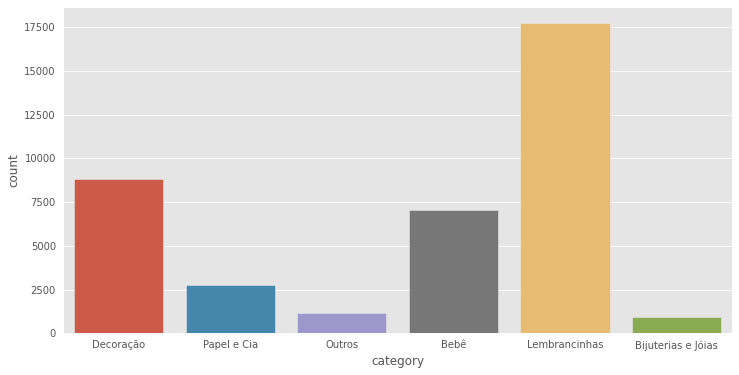

In [38]:
#pesquisas por categoria
fig=plt.figure(figsize=(12,6))
sns.countplot(df2['category']);

##### Quantos produtos distintos há na plataforma?

In [39]:
df2['product_id'].nunique()

29801

##### Qual a distribuição de produtos nos dados? 

In [40]:
df2['product_id'].value_counts()

7557702     14
11130723    12
4225282     12
12716324    11
14155651    11
            ..
4310803      1
12635922     1
8050449      1
16328463     1
11608060     1
Name: product_id, Length: 29801, dtype: int64

##### Quais consultas ocorrem com maior frequência?

In [41]:
df2['query'].value_counts().head(20)

bolsa maternidade                       153
dia dos pais                            148
lembrancinha dia dos pais               127
porta maternidade                       126
batizado                                125
lembrancinha                            122
lembrancinha maternidade                122
lembrancinha batizado                   121
lembrancinhas maternidade               117
presente dia dos pais                   106
saida maternidade                       102
kit bolsa maternidade                    98
lembrancinha de batizado                 95
lembranca maternidade                    92
papel de parede                          86
kit higiene porcelana                    82
lembrancinhas de igreja dia dos pais     79
kit higiene                              78
saida de maternidade                     77
kit berco                                75
Name: query, dtype: int64

##### Qual o número de consultas distintas?

In [42]:
print(df2['query'].nunique())

6397


In [43]:
df2['query'].value_counts().sort_values(ascending=False).head(20)

bolsa maternidade                       153
dia dos pais                            148
lembrancinha dia dos pais               127
porta maternidade                       126
batizado                                125
lembrancinha                            122
lembrancinha maternidade                122
lembrancinha batizado                   121
lembrancinhas maternidade               117
presente dia dos pais                   106
saida maternidade                       102
kit bolsa maternidade                    98
lembrancinha de batizado                 95
lembranca maternidade                    92
papel de parede                          86
kit higiene porcelana                    82
lembrancinhas de igreja dia dos pais     79
kit higiene                              78
saida de maternidade                     77
kit berco                                75
Name: query, dtype: int64

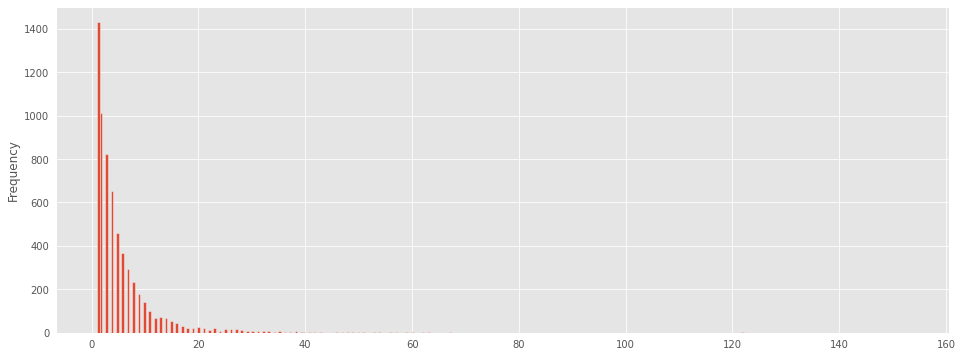

In [44]:
fig = plt.figure(figsize=(16,6))
df2['query'].value_counts().plot.hist(bins=300);

##### Quais consultas ocorrem com maior frequência?

In [45]:
df2['query'].value_counts().sort_values(ascending=False).head(20)

bolsa maternidade                       153
dia dos pais                            148
lembrancinha dia dos pais               127
porta maternidade                       126
batizado                                125
lembrancinha                            122
lembrancinha maternidade                122
lembrancinha batizado                   121
lembrancinhas maternidade               117
presente dia dos pais                   106
saida maternidade                       102
kit bolsa maternidade                    98
lembrancinha de batizado                 95
lembranca maternidade                    92
papel de parede                          86
kit higiene porcelana                    82
lembrancinhas de igreja dia dos pais     79
kit higiene                              78
saida de maternidade                     77
kit berco                                75
Name: query, dtype: int64

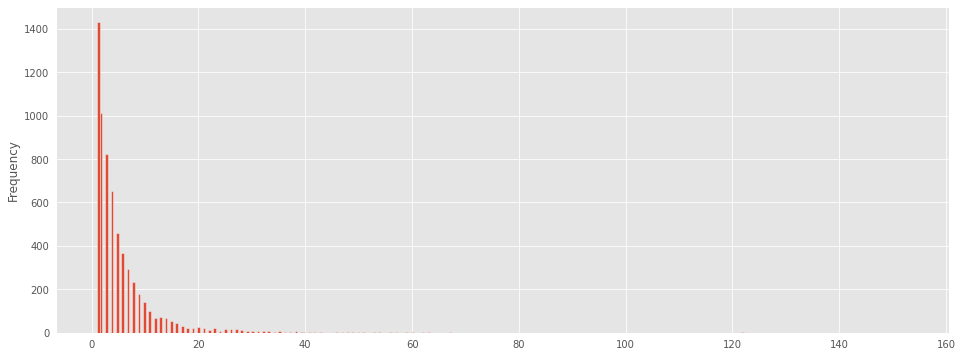

In [46]:
fig = plt.figure(figsize=(16,6))
df2['query'].value_counts().plot.hist(bins=300);

##### Quais tags concatenadas ocorrem com maior frequência?

In [47]:
df2['concatenated_tags'].value_counts().sort_values(ascending=False).head(20)

dia pais             813
lembrancinhas        197
batizado             116
tapetes               88
decoracao             71
dia professores       69
casamento             56
bebe                  47
cortinas              43
especial dia pais     43
tapetes croche        41
baby shark            41
porta maternidade     39
dia pais chaveiro     39
formatura             38
canecas               38
lembrancinha          37
sandalia dia pais     36
branca neve           35
cha revelacao         34
Name: concatenated_tags, dtype: int64

### 4.2 Análise bivariada

In [48]:
df2.columns

Index(['product_id', 'seller_id', 'query', 'search_page', 'position', 'title',
       'concatenated_tags', 'creation_date', 'price', 'weight',
       'express_delivery', 'minimum_quantity', 'view_counts', 'order_counts',
       'category', 'query_length'],
      dtype='object')

#### Quantos produtos há por categoria? 

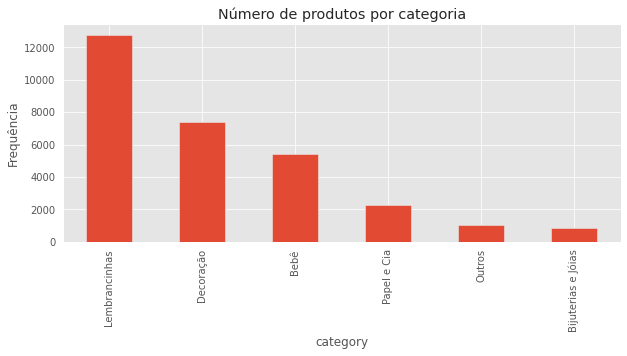

In [49]:
fig = plt.figure(figsize=(10,4))
ax = plt.axes()
ax.set_title("Número de produtos por categoria")
ax.set_ylabel("Frequência")
ax.set_xlabel("Categoria")


df2.groupby('category')['product_id'].nunique().sort_values(ascending=False).plot.bar();

#### Como os preços variam por categoria?

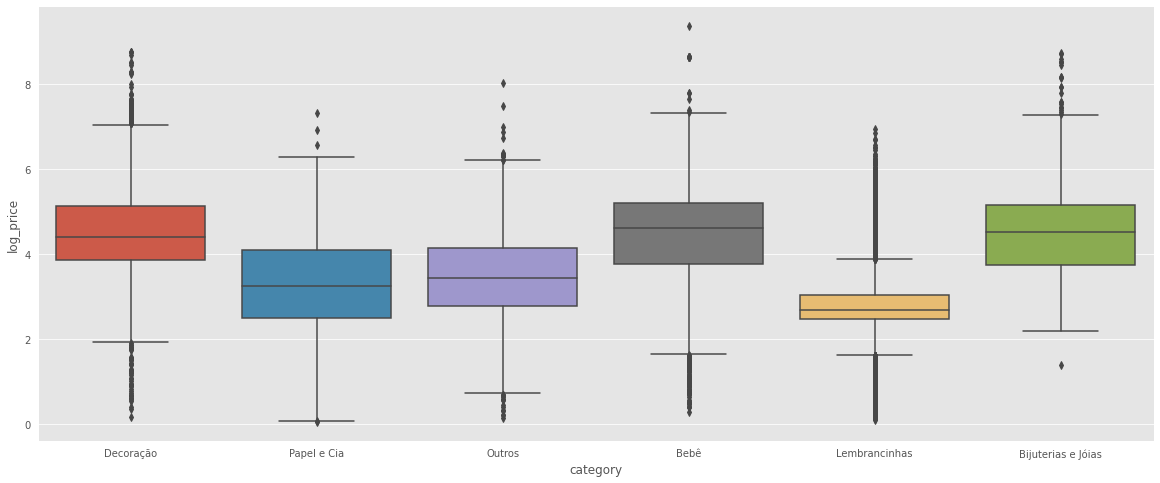

In [50]:
df2['log_price'] = np.log1p(df2['price']);

fig = plt.figure(figsize=(20,8))

sns.boxplot(data=df2, x='category', y='log_price');

**Podemos perceber no gráfico acima que a distribuição de preço difere entre as categorias. Portanto, esta feature é uma boa candidata para o classificador de categorias.**

#### Qual a variação dos atributos dos produtos (peso, preço, etc)? 

In [51]:
df2[['product_id', 'price', 'weight','view_counts', 'order_counts']].groupby(by=['product_id']).agg(['count','min', 'max', 'median', 'mean'])

price                                             weight        \
           count        min        max     median       mean  count   min   
product_id                                                                  
361            2    5.00000   15.84000   10.42000   10.42000      2   0.0   
1426           2   24.27000   26.77000   25.52000   25.52000      2   7.0   
2102           1   10.95000   10.95000   10.95000   10.95000      1   5.0   
2295           1   11.61000   11.61000   11.61000   11.61000      1  56.0   
3528           1    9.05000    9.05000    9.05000    9.05000      1   6.0   
...          ...        ...        ...        ...        ...    ...   ...   
16689822       1   35.34000   35.34000   35.34000   35.34000      1   6.0   
16690454       1  200.48000  200.48000  200.48000  200.48000      1   9.0   
16691829       1   11.35000   11.35000   11.35000   11.35000      1   7.0   
16692023       1    2.00000    2.00000    2.00000    2.00000      1   9.0   
16692953       1  182.59001  182.59001  182.59001  182.59001      1   6.0   

                              view_counts                              \
             max median  mean       count   min   max  median    mean   
product_id                                                              
361          7.0    3.5   3.5           2   182   198   190.0   190.0   
1426        10.0    8.5   8.5           2  3290  3298  3294.0  3294.0   
2102         5.0    5.0   5.0           1   113   113   113.0   113.0   
2295        56.0   56.0  56.0           1    76    76    76.0    76.0   
3528         6.0    6.0   6.0           1  1444  1444  1444.0  1444.0   
...          ...    ...   ...         ...   ...   ...     ...     ...   
16689822     6.0    6.0   6.0           1   913   913   913.0   913.0   
16690454     9.0    9.0   9.0           1   275   275   275.0   275.0   
16691829     7.0    7.0   7.0           1   129   129   129.0   129.0   
16692023     9.0    9.0   9.0           1    53    53    53.0    53.0   
16692953     6.0    6.0   6.0           1   105   105   105.0   105.0   

           order_counts                       
                  count min max median  mean  
product_id                                    
361                   2  23  33   28.0  28.0  
1426                  2   0   0    0.0   0.0  
2102                  1   0   0    0.0   0.0  
2295                  1   0   0    0.0   0.0  
3528                  1   6   6    6.0   6.0  
...                 ...  ..  ..    ...   ...  
16689822              1   0   0    0.0   0.0  
16690454              1   4   4    4.0   4.0  
16691829              1   0   0    0.0   0.0  
16692023              1   0   0    0.0   0.0  
16692953              1   2   2    2.0   2.0  

[29801 rows x 20 columns]

**Como alguns produtos aparecem mais de uma vez no dataset com características distintas, como preço e peso, pode ser interessante utilizar a média destas features ao invés do valor original.**

#### Quais os produtos mais vendidos?

In [52]:
df_mais_vendidos = df2[['product_id', 'order_counts', 'category']].groupby(by=['product_id'])['order_counts'].agg(['mean']).sort_values(by=['mean'], ascending=False).reset_index()               
df_mais_vendidos.columns = ['product_id', 'order_counts_media']


df_mais_vendidos = pd.merge(df_mais_vendidos, df2[['product_id', 'category']], on='product_id', how='left')


display(df_mais_vendidos)


,product_id,order_counts_media,category
0,8733961,2460.0,Bijuterias e Jóias
1,7824167,1586.0,Decoração
2,7824167,1586.0,Decoração
3,15994516,1036.0,Lembrancinhas
4,15994516,1036.0,Lembrancinhas
...,...,...,...
38502,10507742,0.0,Lembrancinhas
38503,1164193,0.0,Lembrancinhas
38504,1164193,0.0,Lembrancinhas
38505,2621533,0.0,Lembrancinhas


#### Quais os produtos mais visualizados?

In [53]:
df_mais_visualizados = df2[['product_id', 'view_counts']].groupby(by=['product_id'])['view_counts'].agg(['mean']).sort_values(by=['mean'], ascending=False).reset_index()               
df_mais_visualizados.columns = ['product_id', 'view_counts_media']

display(df_mais_visualizados)

,product_id,view_counts_media
0,15722213,45010.00
1,6977307,41534.00
2,9836291,34000.60
3,9730357,33518.75
4,8271183,31348.60
...,...,...
29796,14233094,1.00
29797,78953,1.00
29798,14248126,1.00
29799,3175824,1.00


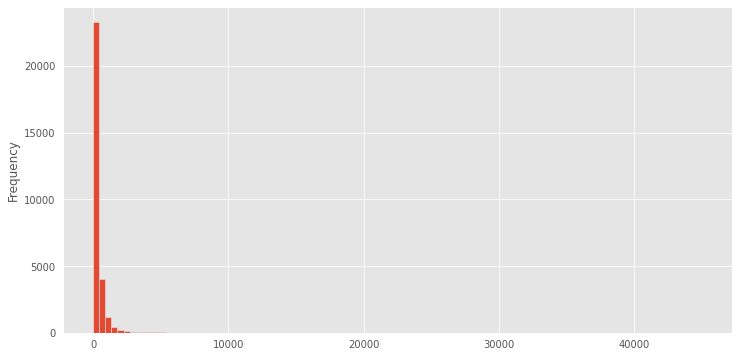

In [54]:
fig = plt.figure(figsize=(12,6))
df_mais_visualizados['view_counts_media'].plot.hist(bins=100);

#### Qual a relação entre as vendas e visualizações dos produtos?

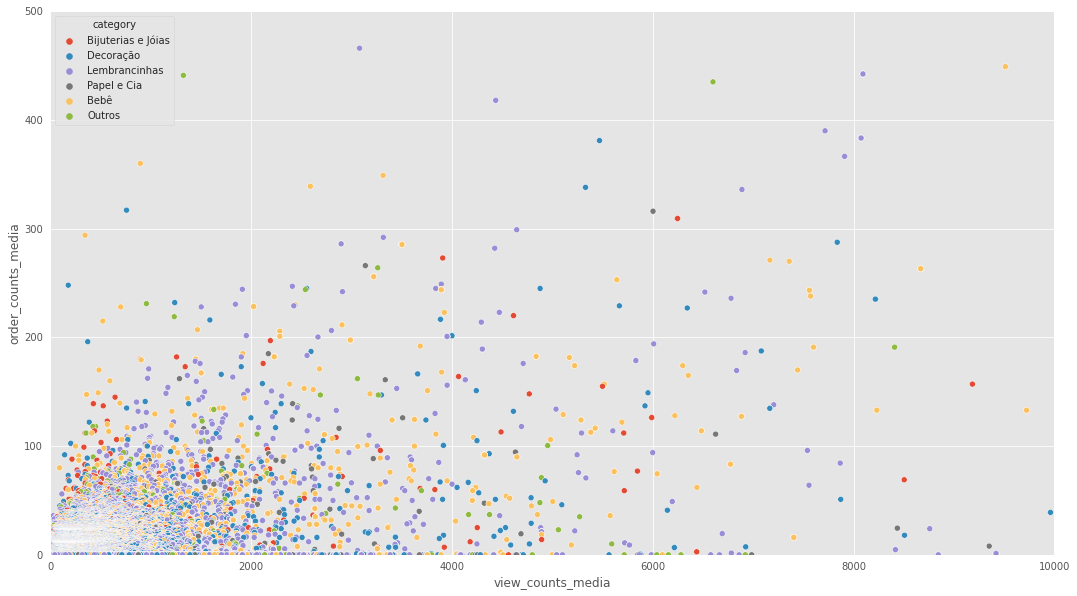

In [55]:
df_vendas_visualizacoes = pd.merge(df_mais_vendidos, df_mais_visualizados, on='product_id')

fig = plt.figure(figsize=(18,10))
ax = plt.axes()

ax.set_xlim([0,10000])
ax.set_ylim([0, 500])

sns.scatterplot(data=df_vendas_visualizacoes, x="view_counts_media", y="order_counts_media", hue='category');

#### Qual o percentual de visualizações do produto que se convertem em vendas?

In [56]:
df_vendas_visualizacoes['taxa_conversao'] = df_vendas_visualizacoes[['view_counts_media', 'order_counts_media']].apply(lambda x: 100*x[1]/max(x[0],1.0), axis=1)
df_vendas_visualizacoes['taxa_conversao'].sort_values(ascending=False)

df_vendas_visualizacoes.head()

,product_id,order_counts_media,category,view_counts_media,taxa_conversao
0,8733961,2460.0,Bijuterias e Jóias,28530.0,8.622503
1,7824167,1586.0,Decoração,1793.5,88.430443
2,7824167,1586.0,Decoração,1793.5,88.430443
3,15994516,1036.0,Lembrancinhas,23571.0,4.395231
4,15994516,1036.0,Lembrancinhas,23571.0,4.395231


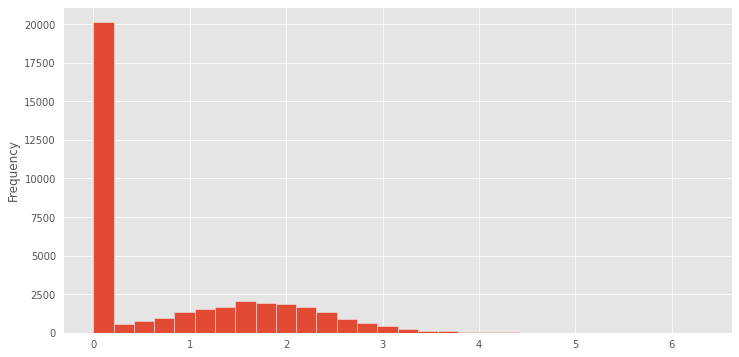

In [57]:
fig = plt.figure(figsize=(12,6))
np.log1p(df_vendas_visualizacoes['taxa_conversao']).plot.hist(bins=30);

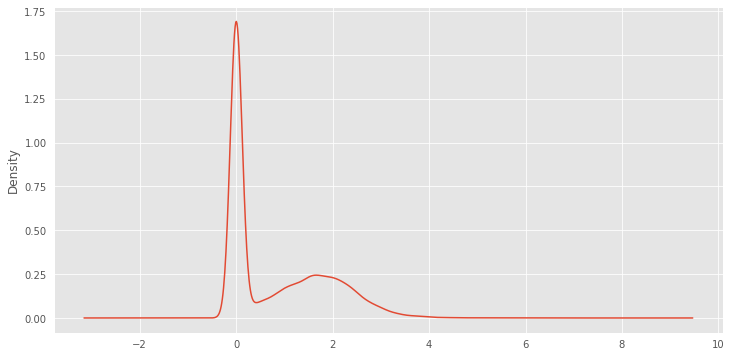

In [58]:
fig = plt.figure(figsize=(12,6))
np.log1p(df_vendas_visualizacoes['taxa_conversao']).plot.kde();

In [59]:
df_vendas_visualizacoes = df_vendas_visualizacoes.drop_duplicates()
df_vendas_visualizacoes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29801 entries, 0 to 38505
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   product_id          29801 non-null  int64  
 1   order_counts_media  29801 non-null  float64
 2   category            29801 non-null  object 
 3   view_counts_media   29801 non-null  float64
 4   taxa_conversao      29801 non-null  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 1.4+ MB


In [60]:
df3 = df2.join(df_vendas_visualizacoes.drop(['category'], axis=1).set_index('product_id'), on='product_id')



#### Como a média de vendas de produto varia por categoria?

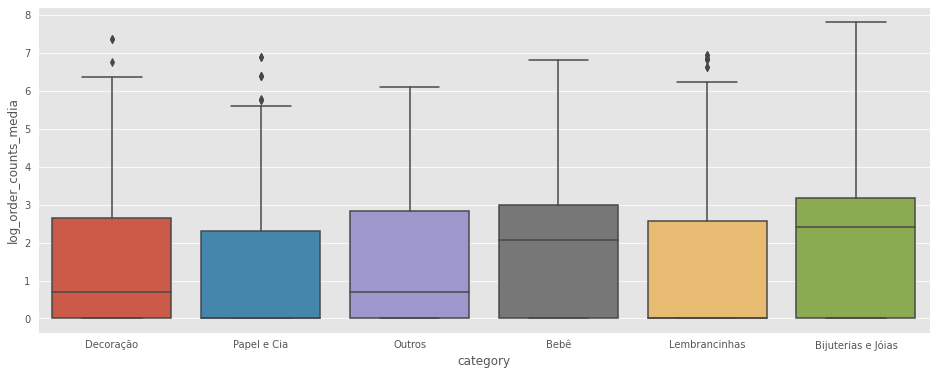

In [61]:
df3['log_order_counts_media'] = np.log1p(df3['order_counts_media']);

fig = plt.figure(figsize=(16,6))

sns.boxplot(data=df3, x='category', y='log_order_counts_media');

df3.drop(['log_order_counts_media'],axis=1);

#### Como a média de visualizações de produto varia por categoria?

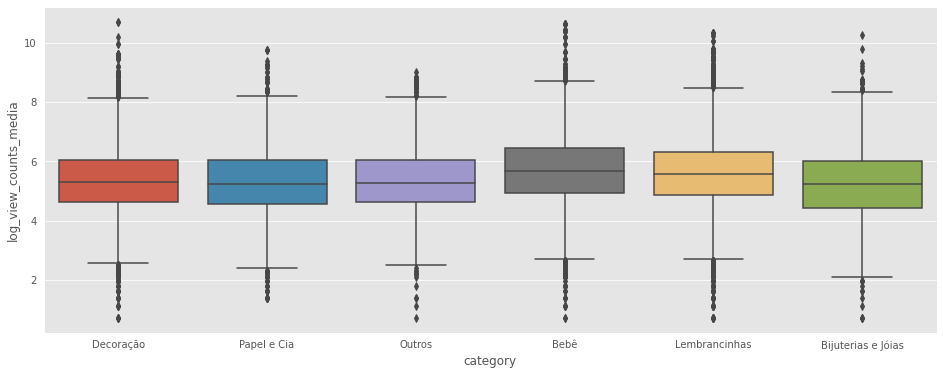

In [62]:
df3['log_view_counts_media'] = np.log1p(df3['view_counts_media']);

fig = plt.figure(figsize=(16,6))

sns.boxplot(data=df3, x='category', y='log_view_counts_media');

df3.drop(['log_view_counts_media'],axis=1);

#### Como a taxa de conversão do produto varia por categoria?

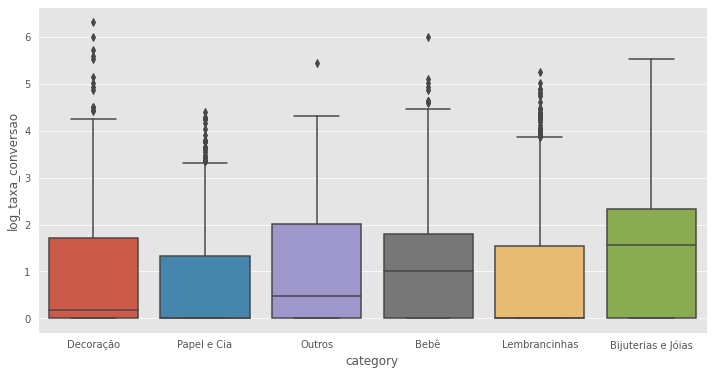

In [63]:
df3['log_taxa_conversao'] = np.log1p(df3['taxa_conversao']);

fig = plt.figure(figsize=(12,6))

sns.boxplot(data=df3, x='category', y='log_taxa_conversao');

df3.drop(['log_taxa_conversao'], axis=1);


#### Como os pesos variam por categoria?

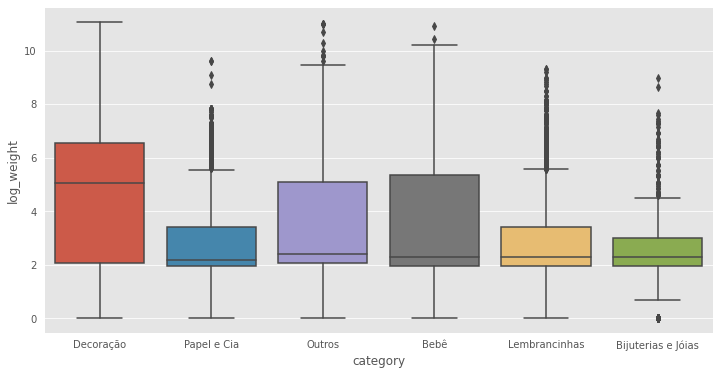

In [64]:
df2['log_weight'] = np.log1p(df2['weight']);

fig = plt.figure(figsize=(12,6))

sns.boxplot(data=df2, x='category', y='log_weight');

Apesar de algumas categorias apresentarem boxes semelhantes, esta feature pode auxiliar a diferenciação entre as classes. Portanto é também uma feature candidata.

### 4.3. Análise multivariada - Há correlação entre as variáveis?

#### 4.1.1. Variáveis numéricas

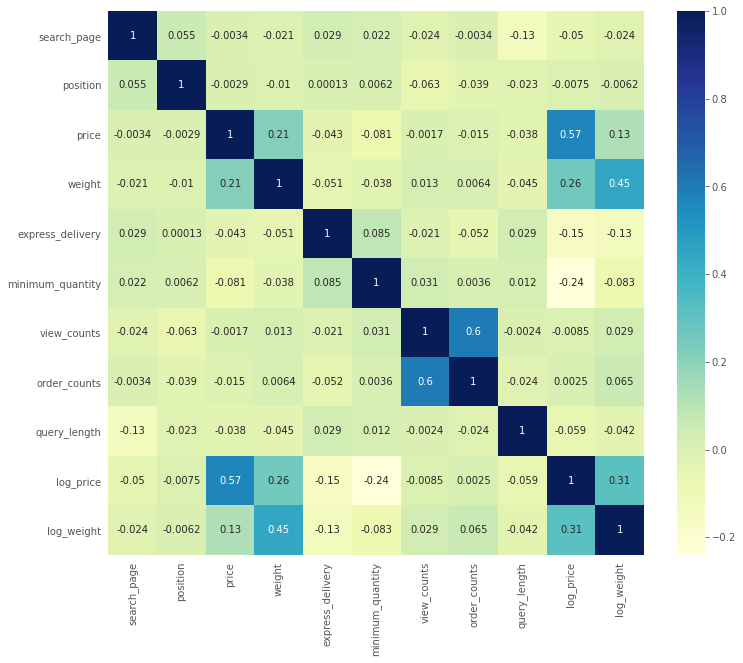

In [65]:
fig = plt.figure(figsize=(12,10))
sns.heatmap(df2.drop(['product_id', 'seller_id'],axis=1).corr(), annot=True, cmap="YlGnBu");

Há correlação significativa apenas entre os atributos 'view_counts' e 'order_counts'

# Parte 2 - Sistema de Classificação de Produtos

---

O objetivo desta etapa é criar um classificador de produtos utilizando o dataset fornecido e as transformações propostas, adotando as ideias geradas durante a análise exploratória.

## Método
- Separação dos dados em treinamento/teste
- Seleção de features
- Criação de um pipeline para facilitar os experimentos com o classificador (além de permitir a aplicação dos mesmos passos ao conjunto de testes ao final do processo)
    - Processamento de linguagem natural
        - CountVectorizer
        - TfidfTransformer
    - Transformação da escala das features numéricas
        - MinMaxScaler
- Serão experimentados 4 métodos com características distintas:   
    - RandomForest
    - KNeighborsClassifier
    - SVC
    - Multinomial Naive Bayes

- A técnica de para geração dos conjuntos de treinamento e validação será a validação cruzada com Stratified K-Folds (sklearn.model_selection.StratifiedKFold), de forma a manter a mesma proporção entre as classes em cada par de conjuntos de treinamento e validação.
- Seleção do melhor utilizando a métrica precisão
    - Considerando que o impacto de falsos positivos é equivalente ao de falsos negativos
- Avaliação do melhor modelo utilizando o conjunto de testes


In [66]:
df_pt2 = df2.copy().drop(['log_price'], axis=1)
df_pt2.head()

,product_id,seller_id,query,search_page,position,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category,query_length,log_weight
0,11394449,8324141,espirito santo,2,6,Mandala Espírito Santo,mandala mdf,2015-11-14 19:42:12,171.890000,1200.0,1,4,244,0,Decoração,14,7.090910
1,15534262,6939286,cartao de visita,2,0,Cartão de Visita,cartao visita panfletos tag adesivos copos lon...,2018-04-04 20:55:07,77.670000,8.0,1,5,124,0,Papel e Cia,16,2.197225
2,16153119,9835835,expositor de esmaltes,1,38,Organizador expositor p/ 70 esmaltes,expositor,2018-10-13 20:57:07,73.920006,2709.0,1,1,59,0,Outros,21,7.904704
3,15877252,8071206,medidas lencol para berco americano,1,6,Jogo de Lençol Berço Estampado,t jogo lencol menino lencol berco,2017-02-27 13:26:03,118.770004,0.0,1,1,180,1,Bebê,35,0.000000
4,15917108,7200773,adesivo box banheiro,3,38,ADESIVO BOX DE BANHEIRO,adesivo box banheiro,2017-05-09 13:18:38,191.810000,507.0,1,6,34,0,Decoração,20,6.230481


In [67]:
df_pt2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38507 entries, 0 to 38506
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   product_id         38507 non-null  int64         
 1   seller_id          38507 non-null  int64         
 2   query              38507 non-null  object        
 3   search_page        38507 non-null  int64         
 4   position           38507 non-null  int64         
 5   title              38507 non-null  object        
 6   concatenated_tags  38507 non-null  object        
 7   creation_date      38507 non-null  datetime64[ns]
 8   price              38507 non-null  float64       
 9   weight             38507 non-null  float64       
 10  express_delivery   38507 non-null  int64         
 11  minimum_quantity   38507 non-null  int64         
 12  view_counts        38507 non-null  int64         
 13  order_counts       38507 non-null  int64         
 14  catego

## Separação dos dados em treinamento/teste

In [68]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit


X = df_pt2.drop(['category'], axis=1)
y = df_pt2['category']


sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
sss.get_n_splits(X, y)

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

## Seleção de features

A feature 'query' deverá obrigatoriamente ser utilizada pelo classificador, uma vez que será a entrada para o sistema final.
Assim, nesta etapa irei identificar as features numéricas mais relevantes.
Para tanto, adotei o classificador Extra Trees, que também pode ser utilizado para identificar as features mais importantes. 

In [69]:
from sklearn.ensemble import ExtraTreesClassifier

features_numericas = X_train.select_dtypes(include=['int64','float64'])


forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0, n_jobs=-1)

forest.fit(features_numericas, y_train)
print(forest.feature_importances_)


[0.07636808 0.09463072 0.02076098 0.07116698 0.1814594  0.08095304
 0.01979015 0.11601932 0.08222452 0.0649563  0.08413927 0.10753126]


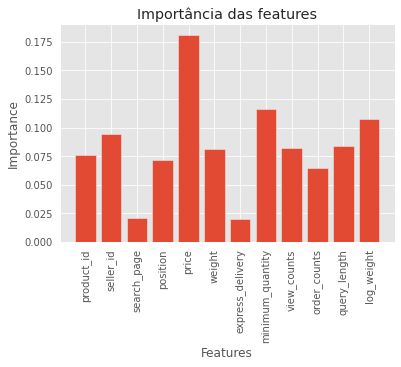

In [70]:
plt.bar(features_numericas.columns, forest.feature_importances_)

plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Importância das features")
plt.xticks(rotation=90)
plt.show()

Portanto as features mais importantes para identificação da categoria são 'price', 'minimum_quantity', 'weight'.
Inicialmente vamos adicionar apenas a feature **price**, uma vez que possui praticamente o dobro da importância da segunda mais importante.

In [71]:
def feature_selector(X, y):
    X_classificador = X[['query', 'price']].values
    Y_classificador = y.to_numpy().ravel()
    return X_classificador, Y_classificador
    

In [72]:
X_classificador, Y_classificador = feature_selector(X_train, y_train);

display(X_classificador.shape)
display(Y_classificador.shape)

(28880, 2)

(28880,)

## Funções para NLP

Remoção de stopwords em português (pacote nltk) e pontuação

In [73]:
import string
with open('data/stopwords_portuguese', 'r') as reader:
   stopwords = [line.strip() for line in reader]



In [74]:
def text_preprocess(text):
    """
    1. remove pontuação
    2. remove stop words
    3. retorna lista de palavras resultante
    """
    
    sem_pontuacao = [char for char in text if char not in string.punctuation]
    
    sem_pontuacao = ''.join(sem_pontuacao)
    
    sem_stop_words = [word for word in sem_pontuacao.split() if word.lower() not in stopwords]
    
    return sem_stop_words

## Criação do pipeline

In [75]:
def make_pipeline_classificador_categoria(model):    

    numeric_features = ['price']
    numeric_transformer = Pipeline(steps=[
        ('scaler', MinMaxScaler())
    ])

    text_features = ['query']
    text_transformer = Pipeline(steps=[
        ('bow', CountVectorizer(analyzer=text_preprocess)),
        ('tfidf', TfidfTransformer())        
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, [1]),
            ('text', text_transformer, [0])
    ])    

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])  
        
    return pipeline


In [76]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler

cv = StratifiedKFold(n_splits=5)

models = [LinearSVC(), MultinomialNB(), KNeighborsClassifier(), RandomForestClassifier(n_jobs=-1)]

for model in models:
    
    pipeline = make_pipeline_classificador_categoria(model)

    score = cross_val_score(pipeline, X=X_classificador, y=Y_classificador, 
                            cv=cv.split(X_classificador,Y_classificador), scoring='precision_weighted')
    
    print("Model:", model)
    print("Median weighted precision score: {0:.3f} (std: {1:.5f})".format(np.median(score), np.std(score)))       

Model: LinearSVC()
Median weighted precision score: 0.843 (std: 0.00525)
Model: MultinomialNB()
Median weighted precision score: 0.827 (std: 0.00427)
Model: KNeighborsClassifier()
Median weighted precision score: 0.824 (std: 0.00470)
Model: RandomForestClassifier(n_jobs=-1)
Median weighted precision score: 0.827 (std: 0.00414)


Os modelos tiveram desempenho semelhante, sendo o **LinearSVC** superior (84.4% de acurácia).

## Treinamento do melhor modelo utilizando todos os dados de treinamento

In [77]:
classificador = make_pipeline_classificador_categoria(LinearSVC())
classificador.fit(X_classificador, Y_classificador)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  [1]),
                                                 ('text',
                                                  Pipeline(steps=[('bow',
                                                                   CountVectorizer(analyzer=<function text_preprocess at 0x7fb411207160>)),
                                                                  ('tfidf',
                                                                   TfidfTransformer())]),
                                                  [0])])),
                ('classifier', LinearSVC())])

## Avaliação do melhor modelo no conjunto de teste

In [78]:
X_classificador_teste, Y_classificador_teste = feature_selector(X_test, y_test)

display(X_classificador_teste.shape)
display(Y_classificador_teste.shape)

(9627, 2)

(9627,)

In [79]:
predictions = classificador.predict(X_classificador_teste)

In [80]:
from sklearn import metrics
print(metrics.classification_report(Y_classificador_teste, predictions))

                    precision    recall  f1-score   support

              Bebê       0.87      0.76      0.81      1756
Bijuterias e Jóias       0.89      0.87      0.88       238
         Decoração       0.84      0.84      0.84      2212
     Lembrancinhas       0.84      0.92      0.88      4440
            Outros       0.75      0.49      0.59       287
       Papel e Cia       0.73      0.61      0.67       694

          accuracy                           0.84      9627
         macro avg       0.82      0.75      0.78      9627
      weighted avg       0.84      0.84      0.83      9627



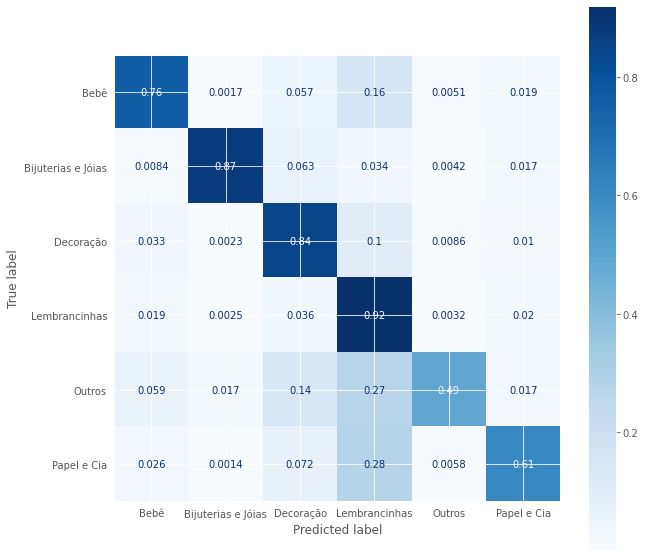

In [81]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes()

metrics.plot_confusion_matrix(classificador, X_classificador_teste, Y_classificador_teste, 
                              cmap=plt.cm.Blues, normalize='true', ax=ax);

plt.show();

## Resultados

**A média ponderada da acurácia obtida nos dados de teste foi de 84%**, valor próximo ao obtido na validação cruzada (84.4%), o que indica que não houve overfitting no treinamento. Assim, o modelo apresentou bom desempenho frente a novos dados, como ocorreria em produção.

Além disso, destaco que não houve ajuste dos parâmetros, que poderia aumentar o desempenho do modelo.

## Treinamento utilizando todos os dados disponíveis (para deploy)

In [82]:
X_classificador_total, Y_classificador_total = feature_selector(X, y)
print(X.shape)
print(y.shape)

(38507, 16)
(38507,)


In [83]:
classificador_categoria_produto = make_pipeline_classificador_categoria(LinearSVC())
classificador_categoria_produto.fit(X_classificador_total, Y_classificador_total)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  [1]),
                                                 ('text',
                                                  Pipeline(steps=[('bow',
                                                                   CountVectorizer(analyzer=<function text_preprocess at 0x7fb411207160>)),
                                                                  ('tfidf',
                                                                   TfidfTransformer())]),
                                                  [0])])),
                ('classifier', LinearSVC())])

## Salvando modelo em arquivo

In [84]:
joblib.dump(classificador_categoria_produto, 'models/classificador_categoria_produto.pkl', compress = 1)

['models/classificador_categoria_produto.pkl']

Teste carregamento do modelo:

In [85]:
classificador_categoria_produto = joblib.load('models/classificador_categoria_produto.pkl')
pred = classificador_categoria_produto.predict(X_classificador_total)
print(metrics.classification_report(Y_classificador_total, pred))


                    precision    recall  f1-score   support

              Bebê       0.90      0.79      0.84      7026
Bijuterias e Jóias       0.92      0.89      0.90       951
         Decoração       0.87      0.88      0.88      8846
     Lembrancinhas       0.86      0.94      0.90     17759
            Outros       0.82      0.59      0.69      1148
       Papel e Cia       0.81      0.63      0.71      2777

          accuracy                           0.86     38507
         macro avg       0.86      0.79      0.82     38507
      weighted avg       0.86      0.86      0.86     38507



# Parte 3 - Sistema de termos de busca
--- 

Como o classificador construído na etapa passada utiliza o termo de busca e o preço para predizer a categoria, iniciarei a investigação das classes de intenção buscando por faixas de preço, utilizando o algoritmo k-means.

Após a determinação do número de classes (grupos) através de testes com o número de centróides, os dados serão rotulados.

Como as faixas de preço não estarão disponíveis a partir do termo de busca, será criado um classificador que indicará o grupo a partir da query de busca.

O dataset será dividido em treinamento/validação e testes. O classificador de intenção será treinado a partir do conjunto de treinamento e seu desempenho será verificado utilizando o conjunto de teste.

In [86]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [87]:
def make_pipeline_clustering(model):

    numeric_transformer = Pipeline(steps=[
        ('scaler', MinMaxScaler())
    ])

    text_features = ['query']
    text_transformer = Pipeline(steps=[
        ('bow', CountVectorizer(analyzer=text_preprocess)),
        ('tfidf', TfidfTransformer())        
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, [0]),
            #('text', text_transformer, [0])
    ])
    
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('cluster', model)
    ])  
        
    return pipeline

In [88]:
df_pt3 = df_pt2.copy()

In [89]:
df_pt3.columns

Index(['product_id', 'seller_id', 'query', 'search_page', 'position', 'title',
       'concatenated_tags', 'creation_date', 'price', 'weight',
       'express_delivery', 'minimum_quantity', 'view_counts', 'order_counts',
       'category', 'query_length', 'log_weight'],
      dtype='object')

In [90]:
df_pt3[['log_price']] = np.log1p(df_pt3[['price']])
df_pt3[['log_view_counts']] = np.log1p(df_pt3[['view_counts']])
df_pt3[['log_order_counts']] = np.log1p(df_pt3[['order_counts']])

X = df_pt3[['log_price','log_view_counts', 'log_order_counts' ]].values

[219.60379200554124, 127.69128051418281, 71.99084758924629, 47.26639065216156, 33.645964631489434, 26.17672417045229, 21.708978591123238, 17.29895353444227]


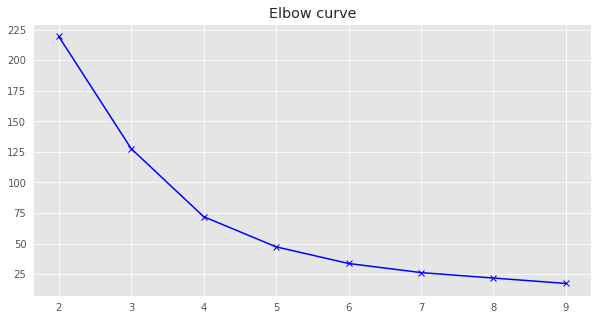

In [91]:
from sklearn.cluster import KMeans, AgglomerativeClustering
import pandas as pd
import seaborn as sns

kmax = 10

K = range(2, 10)

distorsions = []
for k in K:
    kmeans = make_pipeline_clustering(KMeans(n_clusters=k, random_state=0))
    kmeans.fit(X)
    km = kmeans[1]
    distorsions.append(km.inertia_)


print(distorsions)

fig = plt.figure(figsize=(10, 5))
 #,
plt.plot(K, distorsions, 'bx-')
plt.grid(True)
plt.title('Elbow curve');
plt.show()

Realizando experimentos identifiquei que k=3 produz a melhor separação dos dados de acordo com o preço.

In [92]:
kmeans = make_pipeline_clustering(KMeans(n_clusters=3, random_state=0))
kmeans.fit(X)
km = kmeans[1]

/home/igorsr/Projetos/teste_elo7/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


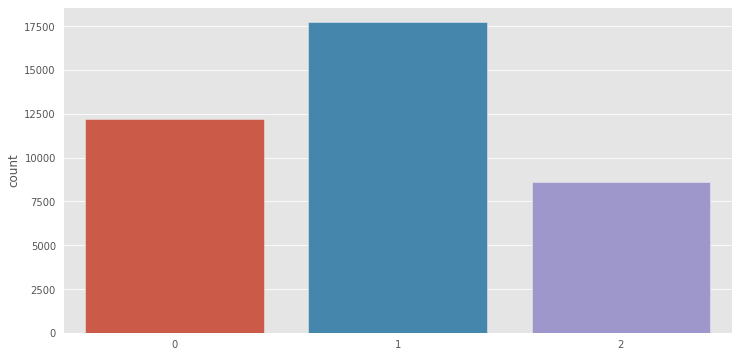

In [93]:
fig = plt.figure(figsize=(12,6))

sns.countplot(km.labels_);

plt.show()

In [94]:
df_pt3_2 = df_pt3.copy()
df_pt3_2["cluster"] = km.labels_

## Estatística descritiva dos clusters

In [95]:
for cluster_label in sorted(df_pt3_2["cluster"].unique()):
    print("cluster ", cluster_label, "(",len(df_pt3_2[df_pt3_2["cluster"]==cluster_label]) , " elementos)")
    display(estatistica_descritiva_atributos_numericos(df_pt3_2[df_pt3_2["cluster"]==cluster_label]))
    print("\n")   

cluster  0 ( 12176  elementos)


,Atributo,Média,Médiana,Std,Min,Max,Intervalo,Skew,Kurtosis
0,product_id,8.321363e+06,8.316898e+06,4.843017e+06,1426.000000,1.668982e+07,1.668840e+07,0.006582,-1.209131
1,seller_id,5.099076e+06,5.046370e+06,2.889748e+06,817.000000,1.011887e+07,1.011805e+07,0.000382,-1.206657
2,search_page,1.368430e+00,1.000000e+00,8.570275e-01,1.000000,5.000000e+00,4.000000e+00,2.606099,6.404964
3,position,1.645754e+01,1.500000e+01,1.156596e+01,0.000000,3.800000e+01,3.800000e+01,0.258597,-1.180423
4,price,5.392536e+01,4.990000e+01,2.210349e+01,23.340000,1.031100e+02,7.977000e+01,0.493182,-0.858717
5,weight,2.425156e+02,1.000000e+01,5.466797e+02,0.000000,1.100600e+04,1.100600e+04,6.653947,70.916204
6,express_delivery,7.078679e-01,1.000000e+00,4.547427e-01,0.000000,1.000000e+00,1.000000e+00,-0.914335,-1.164183
7,minimum_quantity,5.073834e+00,4.000000e+00,6.151388e+00,0.000000,3.000000e+02,3.000000e+02,12.741410,472.627805
8,view_counts,4.552914e+02,1.870000e+02,1.420329e+03,1.000000,4.501000e+04,4.500900e+04,16.544664,380.614896
9,order_counts,1.313691e+01,2.000000e+00,4.347488e+01,0.000000,1.590000e+03,1.590000e+03,16.179025,406.286932




cluster  1 ( 17723  elementos)


,Atributo,Média,Médiana,Std,Min,Max,Intervalo,Skew,Kurtosis
0,product_id,8.357738e+06,8.382949e+06,4.837264e+06,361.000000,1.669202e+07,1.669166e+07,-0.013054,-1.210388
1,seller_id,4.918300e+06,4.731868e+06,2.986856e+06,827.000000,1.011822e+07,1.011740e+07,0.080171,-1.228811
2,search_page,1.579247e+00,1.000000e+00,1.045904e+00,1.000000,5.000000e+00,4.000000e+00,1.842359,2.463319
3,position,1.711838e+01,1.600000e+01,1.158150e+01,0.000000,3.800000e+01,3.800000e+01,0.190224,-1.215105
4,price,1.221411e+01,1.237000e+01,5.175383e+00,0.070000,2.333000e+01,2.326000e+01,-0.346965,-0.034430
5,weight,3.885522e+01,9.000000e+00,1.960828e+02,0.000000,1.100600e+04,1.100600e+04,29.105929,1245.938101
6,express_delivery,8.641878e-01,1.000000e+00,3.425891e-01,0.000000,1.000000e+00,1.000000e+00,-2.126271,2.521313
7,minimum_quantity,2.615161e+01,1.800000e+01,6.228566e+01,0.000000,3.000000e+03,3.000000e+03,21.791175,701.577674
8,view_counts,5.840039e+02,2.680000e+02,1.247959e+03,1.000000,3.137200e+04,3.137100e+04,10.538833,181.563518
9,order_counts,1.202291e+01,0.000000e+00,4.096000e+01,0.000000,1.039000e+03,1.039000e+03,12.648165,241.536807




cluster  2 ( 8608  elementos)


,Atributo,Média,Médiana,Std,Min,Max,Intervalo,Skew,Kurtosis
0,product_id,8.342025e+06,8.403635e+06,4.818169e+06,5834.000000,1.669295e+07,1.668712e+07,-0.002626,-1.197897
1,seller_id,5.072366e+06,4.973691e+06,2.942446e+06,817.000000,1.011887e+07,1.011805e+07,-0.002640,-1.246344
2,search_page,1.486640e+00,1.000000e+00,9.862239e-01,1.000000,5.000000e+00,4.000000e+00,2.161884,3.878455
3,position,1.702707e+01,1.600000e+01,1.161733e+01,0.000000,3.800000e+01,3.800000e+01,0.200786,-1.217058
4,price,2.745827e+02,1.845400e+02,3.895135e+02,103.150000,1.150938e+04,1.140623e+04,10.997644,180.228260
5,weight,1.193164e+03,9.000000e+00,3.658031e+03,0.000000,6.500900e+04,6.500900e+04,8.509416,102.518413
6,express_delivery,7.115474e-01,1.000000e+00,4.530427e-01,0.000000,1.000000e+00,1.000000e+00,-0.934059,-1.127796
7,minimum_quantity,4.275790e+00,4.000000e+00,4.339658e+00,0.000000,1.480000e+02,1.480000e+02,10.144955,277.213478
8,view_counts,5.939159e+02,2.850000e+02,1.702547e+03,1.000000,4.154400e+04,4.154300e+04,15.867873,320.596508
9,order_counts,1.429275e+01,2.000000e+00,4.915169e+01,0.000000,2.460000e+03,2.460000e+03,20.732685,790.974952


## Classes

Faixas de preço: 
1. Entre 0.07 e 23.71;
2. Entre 23.72 e 105.08;
3. Entre 105.09 e 11509.38.

In [96]:
classes_intencao_usuario = [
                    {'id': 0,
                     'nome': 'Preço entre 23.72 e 105.08',
                     'price_min': 23.72,
                     'price_max': 105.08,
                     'price_median': 50.340
                    },
                    {'id': 1,
                     'nome': 'Preço entre 0.07 e 23.71',
                     'price_min': 0.07,
                     'price_max': 23.71,
                     'price_median': 12.40
                    },
                    {'id': 2,
                     'nome': 'Preço entre 105.09 e 11509.3',
                     'price_min': 105.093,
                     'price_max': 11509.38,
                     'price_median': 187.32
                    }
                   ]

In [97]:
joblib.dump(classes_intencao_usuario, 'data/classes_intencao_usuario.pkl', compress = 1)

['data/classes_intencao_usuario.pkl']

## Qual a distribuição de preços por cluster?

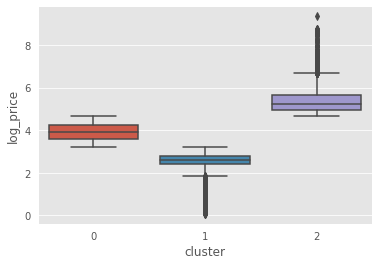

In [98]:
sns.boxplot(data=df_pt3_2, x='cluster', y='log_price');

## Qual a distribuição de preços por cluster por categoria?

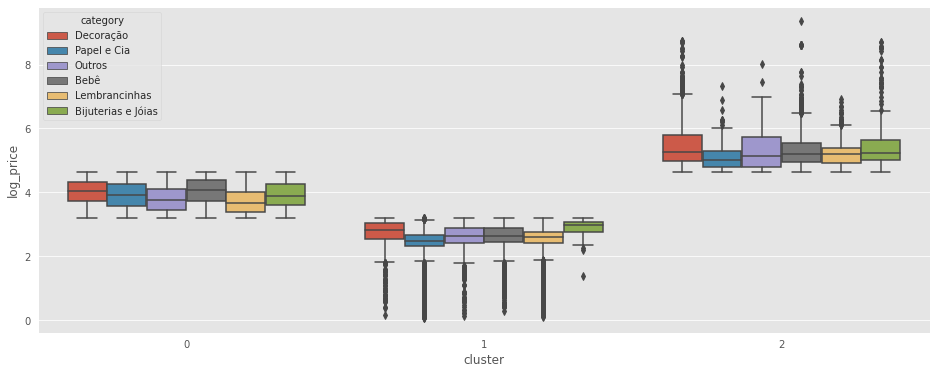

In [99]:
fig = plt.figure(figsize=(16,6))
sns.boxplot(data=df_pt3_2, x='cluster', y='log_price', hue='category');

## Classificador

### Separação dos dados em treinamento/teste

In [100]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold

X = df_pt3_2[['query']]
y = df_pt3_2[['cluster']]

print(X.shape)
print(y.shape)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
sss.get_n_splits(X, y)

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


(38507, 1)
(38507, 1)


In [101]:
def feature_selector_classificador_intencao(X, y):
    X_classificador = X[['query']].values
    Y_classificador = y.to_numpy().ravel()
    return X_classificador, Y_classificador
    

In [102]:
X_classificador_intencao, Y_classificador_intencao = feature_selector_classificador_intencao(X_train, y_train)

display(X_classificador_intencao.shape)
display(X_classificador_intencao.shape)

(26954, 1)

(26954, 1)

### Treinamento de classificadores com validação cruzada

In [103]:

def make_pipeline_classificador_intencao(model):
    
    text_transformer = Pipeline(steps=[
        ('tfidf', TfidfVectorizer(analyzer=text_preprocess))        
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('text', text_transformer, [0])
    ])    

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])  
        
    return pipeline

In [104]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5)

models = [LinearSVC(class_weight='balanced'),  MultinomialNB(), RandomForestClassifier(class_weight='balanced',  n_jobs=-1)]

for model in models:
    
    pipeline = make_pipeline_classificador_intencao(model)

    score = cross_val_score(pipeline, X=X_classificador_intencao, y=Y_classificador_intencao, 
                            cv=cv, scoring='precision_weighted')
    
    print("Model:", model)
    print("Median precision_weighted: {0:.3f} (std: {1:.5f})".format(np.median(score), np.std(score)))       

Model: LinearSVC(class_weight='balanced')
Median precision_weighted: 0.749 (std: 0.00749)
Model: MultinomialNB()
Median precision_weighted: 0.732 (std: 0.00876)
Model: RandomForestClassifier(class_weight='balanced', n_jobs=-1)
Median precision_weighted: 0.748 (std: 0.00603)


Melhor desempenho: **LinearSVC(class_weight='balanced')**

### Treinamento do melhor modelo utilizando todos os dados de treinamento

In [105]:
classificador_intencao = make_pipeline_classificador_intencao(LinearSVC(class_weight='balanced', max_iter=10000))
classificador_intencao.fit(X_classificador_intencao, Y_classificador_intencao);

### Avaliação do melhor modelo no conjunto de teste

In [106]:
X_classificador_teste, Y_classificador_teste = feature_selector_classificador_intencao(X_test, y_test)
X_classificador_teste.shape

(11553, 1)

In [107]:
predictions = classificador_intencao.predict(X_classificador_teste)

In [108]:
from sklearn import metrics
print(metrics.classification_report(Y_classificador_teste, predictions))

              precision    recall  f1-score   support

           0       0.67      0.63      0.65      3653
           1       0.82      0.86      0.84      5317
           2       0.70      0.70      0.70      2583

    accuracy                           0.75     11553
   macro avg       0.73      0.73      0.73     11553
weighted avg       0.75      0.75      0.75     11553



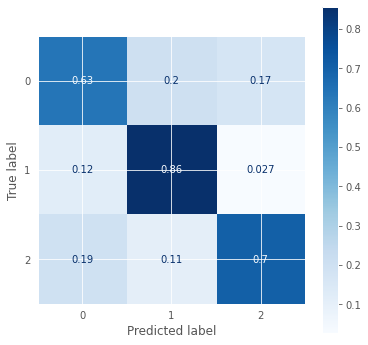

In [109]:
fig = plt.figure(figsize=(6,6))
ax = plt.axes()

metrics.plot_confusion_matrix(classificador_intencao, X_classificador_teste, Y_classificador_teste, 
                              cmap=plt.cm.Blues, normalize='true', ax=ax);

plt.show();

## Resultados 
---

O classificador obteve acurácia média ponderada de 74%.

## Treinamento utilizando todos os dados disponíveis (para deploy)

In [110]:
X_classificador_intencao_total, Y_classificador_intencao_total = feature_selector_classificador_intencao(X, y)

classificador_intencao = make_pipeline_classificador_intencao(LinearSVC(class_weight='balanced', max_iter=10000))
classificador_intencao.fit(X_classificador_intencao_total, Y_classificador_intencao_total);

## Salvando modelo em arquivo

In [111]:
joblib.dump(classificador_intencao, 'models/classificador_intencao.pkl')

['models/classificador_intencao.pkl']

Teste carregamento do modelo:

In [ ]:
classificador_intencao = joblib.load('models/classificador_intencao.pkl')
pred = classificador_intencao.predict(X_classificador_intencao_total)
print(metrics.classification_report(Y_classificador_intencao_total, pred))


## Exemplos
---

Nestes exemplos irei fazer uma amostragem aleatória de cada cluster e predizer um elemento de cada, porém alterando a query, para verificar a robustez da classificação.

In [ ]:
df_pt3_2[df_pt3_2['cluster']==0].sample(3, random_state=0)

In [ ]:
df_pt3_2[df_pt3_2['cluster']==1].sample(3, random_state=0)

In [ ]:
df_pt3_2[df_pt3_2['cluster']==2].sample(3, random_state=0)

In [ ]:
queries = pd.DataFrame(data={'query':['lembrancinha para anunciar gravidez',
                                      'aromatizador lembrancinha', 
                                      'kit berco']})
pred = classificador_intencao.predict(queries.values)

for index,classe_id in enumerate(pred):
    print(queries.iloc[index]['query'], ": ", classes_intencao_usuario[classe_id], "\n") 


Nestes exemplos o modelo classificou corretamente as consultas de acordo com a faixa de preço dos produtos.

A seguir, utilizei alguns produtos encontrados nos site para verificar se a faixa de preço indicada pelo modelo é coerente com dados reais:

- Apostila Digital Pocoyo
    - Preço: 24,90
    
- QUADRO BATMAN (TAMANHO A4)
    - Preço: 50,00

- Par De Aliança 6mm ( Prata ) Banhada com banho de ouro 18k
    - Preço: 320,00
    
- Kit Para Decoração De Sala De Aula
    - Preço: 194,30
    
- Body Personalizado
    - Preço: 24,99





In [ ]:
queries = pd.DataFrame(data={'query':['Apostila Digital Pocoyo',
                                      'Par De Aliança 6mm ( Prata ) Banhada com banho de ouro 18k', 
                                      'Kit Decoração De Sala De Aula',
                                     'QUADRO BATMAN (TAMANHO A4)',
                                     'body personalizado']})
pred = classificador_intencao.predict(queries.values)

for index,classe_id in enumerate(pred):
    print(queries.iloc[index]['query'], ":", classes_intencao_usuario[classe_id]['nome'], "\n") 



# Parte 5
---

Nesta etapa os sistemas de classificação de categoria e intenção serão integrados. 

A partir de uma query, o sistema deve identificar a categoria e a intenção do usuário.
Além disso, um sistema de recomendação irá indicar 10 produtos de acordo com a categoria e faixa de preço desejada pelo usuário.

Funcionamento do sistema final:

- Entrada
    - Termo de busca qualquer
- Saídas
    1. A categoria do termo de busca
    2. O nome da classe de intenção do usuário
    3. Uma lista com o id e o título dos dez produtos recomendados




In [ ]:
df_pt5 = df_pt3_2.copy()

## Sistema de recomendação

- Entradas
    - Categoria
    - Faixa de preço desejada
- Saídas
    - Uma lista com o id e o título dos dez produtos recomendados.
    
Inicialmente, os produtos serão filtrados de acordo com categoria e faixa de preço.
Serão então retornados os 10 produtos mais buscados, de acordo com a média de visualizações (feature 'view_counts')

Criarei um dataset de produtos contendo seu id, preço médio, título e categoria para facilitar a busca e recomendação.

In [ ]:
df_produtos = df_pt5[['product_id', 'view_counts', 'price']].groupby(by=['product_id']).agg(['mean']).reset_index().copy()             
df_produtos.columns = ['product_id', 'view_counts', 'price']


In [ ]:
df_produtos = df_produtos.sort_values(by=['product_id'])
df_produtos

In [ ]:
df_produtos = pd.merge(df_produtos, df_pt5[['product_id', 'category', 'title']].drop_duplicates(), on=['product_id'], how='left') 
df_produtos.to_csv('data/produtos.csv')    
df_produtos
           

In [ ]:
def recomenda_produtos_mais_desejados(categoria, classe_intencao, df_produtos):

    df_filtrado = df_produtos[(df_produtos['category'] == categoria) & (df_produtos['price'] >= classe_intencao['price_min']) & (df_produtos['price'] <= classe_intencao['price_max'])]

    produtos_recomendados = df_filtrado.sort_values(by=['view_counts'], ascending=False).head(10)

    return produtos_recomendados[['product_id', 'title']]

    

Exemplo de uso:

In [ ]:
categoria = 'Decoração'
classe_intencao = classes_intencao_usuario[0]
recomenda_produtos_mais_desejados(categoria, classe_intencao, df_produtos)

## Sistema de classificação de intenção
---

- Entrada
    - Termo de busca
- Saída:
    - Classe de intenção do usuário

In [ ]:
def classifica_intencao_query(query):
    
    classes_intencao_usuario = joblib.load('data/classes_intencao_usuario.pkl')    
    queries = pd.DataFrame(data={'query':[query]})
    classe_id = int(classificador_intencao.predict(queries.values))
    return classes_intencao_usuario[classe_id]

Exemplo de uso:

In [ ]:
classe = classifica_intencao_query('Caneca decorada')
print(classe['nome'])

## Sistema de classificação de categoria
---
 
- Entradas
    - query
    - price
- Saída
    - categoria

Como a classe de intenção obtida a partir da query nos fornece uma faixa de preço, irei analisar se estes valores podem ser utilizados na predição de categoria.

In [ ]:
def classifica_categoria_produto(query, price):
    
    classificador_categoria_produto = joblib.load('models/classificador_categoria_produto.pkl')    
    consulta = pd.DataFrame(data={'query':[query], 'price': [price]})
    pred = classificador_categoria_produto.predict(consulta.values)
    
    return pred[0]

In [ ]:
df_pt5[df_pt5['category'] == 'Bebê'].sample(3, random_state=1)

Exemplo de uso:

In [ ]:
categoria = classifica_categoria_produto('kit higiene bebe', 300)
print(categoria)

## Integração - Sistema final

In [ ]:
def sistema_hibrido(query):
    
    classificador_categoria_produto = joblib.load('models/classificador_categoria_produto.pkl')
    classificador_intencao = joblib.load('models/classificador_intencao.pkl')
    classes_intencao_usuario = joblib.load('data/classes_intencao_usuario.pkl')
    
    
    classe_intencao = classifica_intencao_query(query)

    price_median = classe_intencao['price_median']
    categoria  = classifica_categoria_produto(query, price_median)

    print(f'"{categoria}"')
    print(f'"{classe_intencao["nome"]}"')
    
    produtos_recomendados = recomenda_produtos_mais_desejados(categoria, classe_intencao, df_produtos)

    for ind in produtos_recomendados.index:
         print(f'"{produtos_recomendados["product_id"][ind]},{produtos_recomendados["title"][ind]}"')
        
        

In [ ]:
query = 'anel solitário'
sistema_hibrido(query)